## Analysis notebook for atmosphere NetCDF files

### Define utils

In [1]:
import numpy as np
import netCDF4 as nc
import glob
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
from scipy.interpolate import PchipInterpolator



In [2]:
from proteus.config import read_config

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [3]:
%matplotlib inline
# %matplotlib inline

In [4]:
def readncdf(f):

    ds = nc.Dataset(f)
    vars = list(ds.variables.keys())

    nlev_c = len(ds.variables["p"][:])
    nlev_l = len(ds.variables["pl"][:])
    tsurf  = float(ds.variables["tmp_surf"][:])
    psurf  = float(ds.variables["pl"][-1])
    gases  = [str(bytearray(s).decode()).strip() for s in ds.variables["gases"][:]]
    asf    = float(ds.variables["toa_heating"][:])

    data = {
        "nlev_c":       nlev_c,
        "nlev_l":       nlev_l,
        "tmp_surf":     tsurf,
        "psurf":        psurf,
        "gases":        gases,
        "toa_heating":  asf,
    }

    for k in vars:
        if k in data.keys():
            continue
        var = ds.variables[k][:]
        try:
            data[k] = np.array(ds.variables[k][:], dtype=float)
        except:
            continue

    ds.close()
    return data

def readrun(f):
    print("Reading files in '%s'..." % f)
    ncdfs = glob.glob(f+"/data/*_atm.nc")
    if len(ncdfs) == 0:
        raise Exception("No files found!")
    years = [float(s.split("/")[-1].split("_")[0]) for s in ncdfs]
    mask = np.argsort(years)
    ncdfs = np.array([ncdfs[i] for i in mask])
    years = np.array([years[i] for i in mask])
    data  = np.array([readncdf(f) for f in ncdfs])
    print("    Done reading %d files" % len(years))
    print("    Final time = %1.3e years" % years[-1])
    return years, data


### Do analysis

In [5]:
years, data = readrun("../output/trappist1c/case_00008/")

Reading files in '../output/trappist1c/case_00008/'...
    Done reading 335 files
    Final time = 7.754e+07 years


In [6]:
print(list(data[0].keys()))

['nlev_c', 'nlev_l', 'tmp_surf', 'psurf', 'gases', 'toa_heating', 'tmp_int', 'instellation', 'inst_factor', 'bond_albedo', 'tmagma', 'tfloor', 'tceiling', 'planet_radius', 'surf_gravity', 'zenith_angle', 'cond_skin_d', 'cond_skin_k', 'p', 'pl', 'tmp', 'tmpl', 'z', 'zl', 'dz', 'gravity', 'cp', 'mmw', 'x_gas', 'cloud_mmr', 'fl_D_LW', 'fl_U_LW', 'fl_N_LW', 'fl_D_SW', 'fl_U_SW', 'fl_N_SW', 'fl_D', 'fl_U', 'fl_N', 'fl_cnvct', 'fl_cndct', 'fl_latent', 'fl_tot', 'fl_dif', 'hrate', 'Kzz', 'bandmin', 'bandmax', 'ba_D_LW', 'ba_U_LW', 'ba_N_LW', 'ba_D_SW', 'ba_U_SW', 'ba_N_SW', 'contfunc', 'albedo_s']


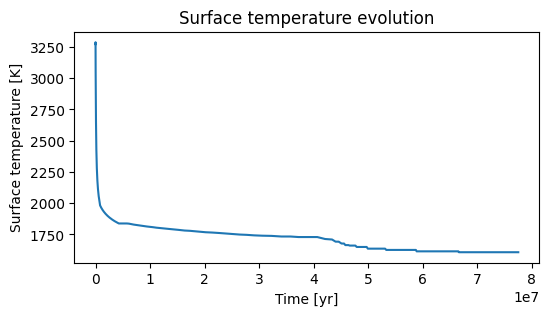

In [7]:
fig,ax = plt.subplots(figsize=(6,3))
yarr = [d["tmp_surf"] for d in data]
ax.plot(years, yarr)
ax.set_xlabel("Time [yr]")
ax.set_ylabel("Surface temperature [K]")
ax.set_title("Surface temperature evolution")
plt.show()

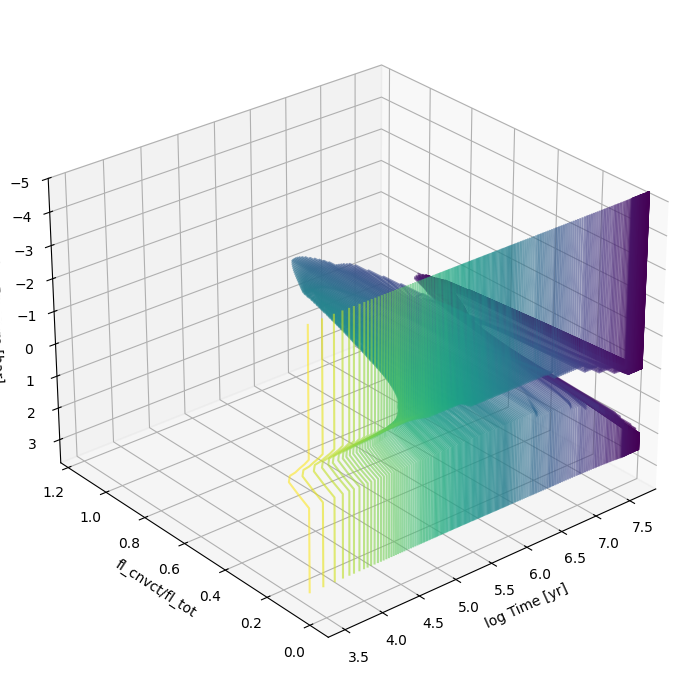

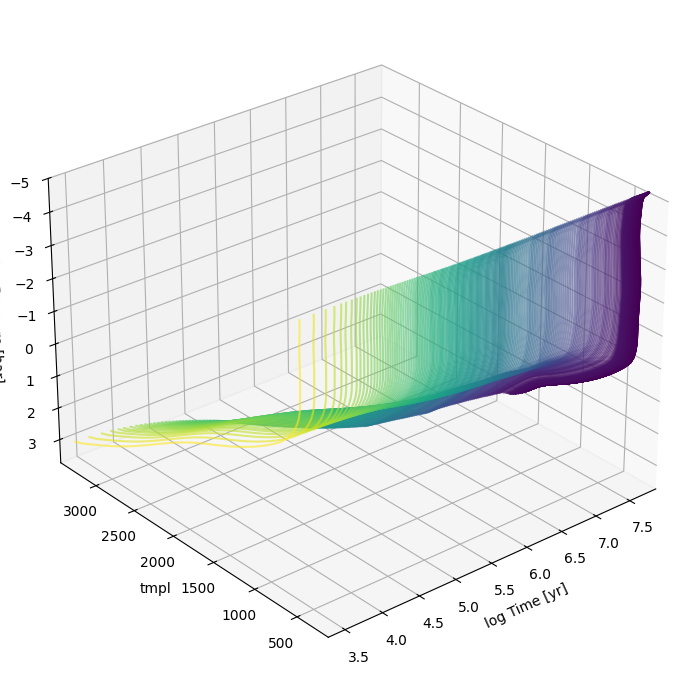

In [8]:
def plot_3d(yrs, dat, key1, key2):

    fig = plt.figure(figsize=(7,8))
    ax = fig.add_subplot(projection='3d',computed_zorder=True)

    idx_start = 4

    # divider = make_axes_locatable(ax)
    # cax = divider.append_axes('default', size='5%', pad=0.05)
    norm = mpl.colors.LogNorm(vmin=max(yrs[idx_start],1), vmax=yrs[-1])
    sm = plt.cm.ScalarMappable(cmap='viridis_r', norm=norm)
    sm.set_array([])
    # cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
    # cbar.set_label("Time [yr]")

    # ax.axvline(x=0, color='black', lw=0.8)

    pmin, pmax = 0, 2
    for i in range(len(dat)-1, idx_start-1,-1):
        y=yrs[i]
        if len(key2) > 0:
            x_plt = dat[i][key1]/dat[i][key2]
        else:
            x_plt = dat[i][key1]
        y_plt = np.log10(dat[i]["pl"]*1.0e-5)

        pmin = min(pmin, np.amin(y_plt))
        pmax = max(pmin, np.amax(y_plt))
        ax.plot(np.ones(len(x_plt))*np.log10(y), x_plt,zs=y_plt,color=sm.to_rgba(y), alpha=0.6)

        # print(y," : ",x_plt[0])
        # ax.plot(x_plt,y_plt, label=str(y))

    ax.set_xlabel("log Time [yr]")
    if len(key2) > 0:
        ax.set_ylabel("%s/%s"%(key1,key2))
    else:
        ax.set_ylabel("%s"%(key1))
    ax.set_zlabel("log Pressure [bar]")
    ax.set_zlim(pmax+1, pmin)
    ax.set_xlim(np.log10(yrs[-1]), np.log10(yrs[idx_start]))
    ax.invert_yaxis()
    ax.view_init(elev=28., azim=50, roll=0)
    plt.tight_layout()

    plt.show()


plt.close("all")
plot_3d(years, data, "fl_cnvct", "fl_tot")
# plot_3d(years, data, "fl_cnvct", "")
plot_3d(years, data, "tmpl", "")

In [9]:
runs = range(8,16,1)
data = {}
conf = {}
for r in runs:
    folder ="../output/trappist1c/case_%05d/"%r
    y,d = readrun(folder)
    data[r] = (y,d)
    conf[r] = read_config(folder+"init_coupler.toml")

Reading files in '../output/trappist1c/case_00008/'...
    Done reading 335 files
    Final time = 7.754e+07 years
Reading files in '../output/trappist1c/case_00009/'...
    Done reading 476 files
    Final time = 2.453e+08 years
Reading files in '../output/trappist1c/case_00010/'...
    Done reading 244 files
    Final time = 1.304e+08 years
Reading files in '../output/trappist1c/case_00011/'...
    Done reading 218 files
    Final time = 1.148e+08 years
Reading files in '../output/trappist1c/case_00012/'...
    Done reading 530 files
    Final time = 3.293e+08 years
Reading files in '../output/trappist1c/case_00013/'...
    Done reading 236 files
    Final time = 6.100e+07 years
Reading files in '../output/trappist1c/case_00014/'...
    Done reading 525 files
    Final time = 2.195e+08 years
Reading files in '../output/trappist1c/case_00015/'...
    Done reading 510 files
    Final time = 2.120e+08 years


In [10]:
# cols = ["winter","autumn","cool"]
nax = len(runs)
cols = ["viridis"]*nax

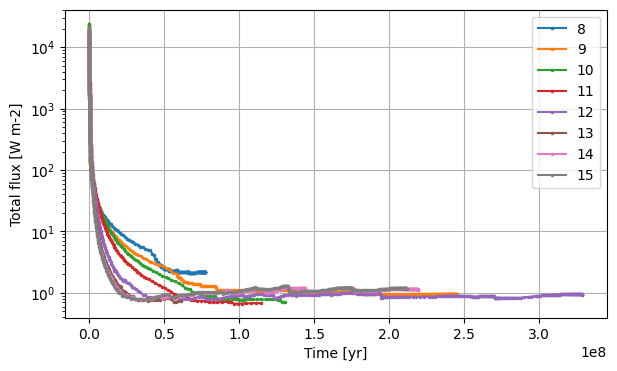

In [11]:
plt.close("all")
fig,ax = plt.subplots(1,1, figsize=(7,4))

for i,r in enumerate(data.keys()):
    yrs = data[r][0]
    dat = data[r][1]

    x,y = [],[]
    for j in range(4,len(yrs),1):
        x.append(yrs[j])
        y.append(abs(dat[j]["fl_tot"][0]))

    ax.plot(x,y,label=r, markersize=3, marker='.')

ax.set_yscale("log")
ax.legend()
ax.set_ylabel('Total flux [W m-2]')
ax.set_xlabel("Time [yr]")
ax.grid(zorder=-2)
plt.show()

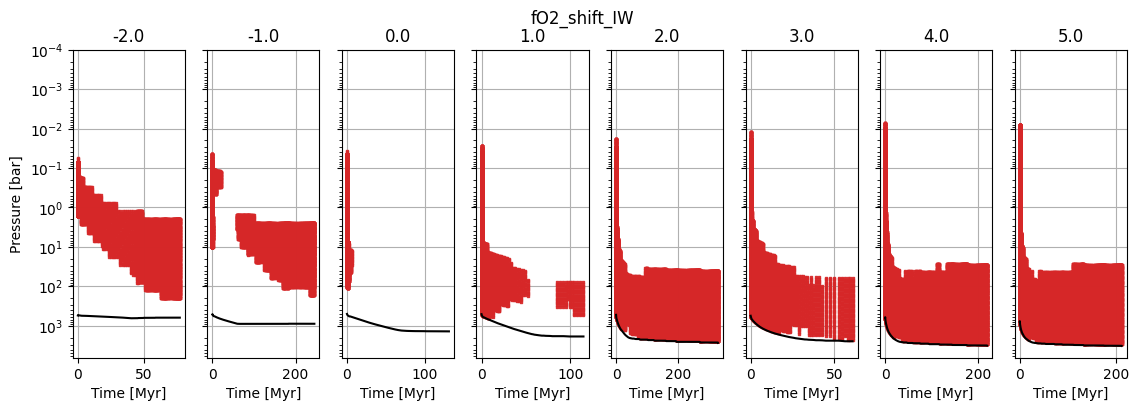

In [23]:

fig,axs = plt.subplots(1,nax,figsize=(1.7*nax,4), sharey=True)

ymin = 1e-4
ymax = 1e1
xmin = 1.0e-5
xmax = 1

itp_points = 200
interpolate = True
title_key = "fO2_shift_IW"

c = 'tab:red'

for i,r in enumerate(data.keys()):
    yrs = data[r][0]
    dat = data[r][1]

    psurf = []
    times = []

    mask_xs = []
    mask_ys = []
    for j in range(len(yrs)):

        # time
        t = yrs[j]/1e6
        if t < xmin:
            continue
        times.append(t)

        # pressure array
        y = dat[j]["pl"]*1e-5
        psurf.append(np.amax(y))
        ymax = max(ymax, np.amax(y))

        # value to use as mask statistic
        val = abs(dat[j]["fl_cnvct"]/dat[j]["fl_tot"])

        # interpolate y and val
        if interpolate:
            itp = PchipInterpolator(y, val)
            y = np.logspace(np.log10(y[0]), np.log10(y[-1]), itp_points)
            val = itp(y)

        mask = np.argwhere(val>1.0e-5)

        y = y[mask]
        mask_ys.extend(list(y))
        x = np.ones(len(y)) * t
        mask_xs.extend(list(x))

    axs[i].scatter(mask_xs,mask_ys,color=c, s=2, alpha=0.9, zorder=2, marker=',')
    axs[i].plot(times, psurf, color='k', zorder=3)
    xmax = max(xmax, np.amax(times))

for i,r in enumerate(data.keys()):
    # axs[i].set_xlim(left=xmin, right=xmax*2)
    # axs[i].set_xscale("log")
    axs[i].set_xlabel("Time [Myr]")

    axs[i].set_title(conf[r][title_key])
    axs[i].grid(zorder=-1)


axs[0].set_ylim(top=ymin, bottom=ymax*2)
axs[0].set_yscale("log")
axs[0].set_ylabel("Pressure [bar]")

# fig.tight_layout()
fig.suptitle(title_key)
plt.show()
